# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples

In [1]:
TGT='Reply'
PRFX='Reply0405_4'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(1e6)#int(1e5)
trnsz = int(5e6)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.set_verbosity(optuna.logging.ERROR)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(1000000, 24)


retwt          0.113135
reply          0.027688
like           0.438804
retwt_cmmnt    0.007750
dtype: float64

CPU times: user 7.01 s, sys: 760 ms, total: 7.77 s
Wall time: 7.77 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(18500000, 24)


retwt          0.112985
reply          0.027410
like           0.439133
retwt_cmmnt    0.007793
dtype: float64

CPU times: user 2min 13s, sys: 13.5 s, total: 2min 26s
Wall time: 2min 27s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(5000000, 24) 0.1014178
18500000 507089 5000000 507089


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
11,101\t22734\t19540\t10393\t124\t76456\t22201\t1...,NaN,F11BD399C084D3035209F62EC72C0E6A,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581044002,CFF9C8C70792DC31C769F29CBFA2FEBE,972,811,False,1575970944,0DD2B48B86395C04C36C377F0F499CC4,741,736,False,1563093560,True,False,True,True,False
32,101\t100397\t11447\t119\t100397\t11447\t119\t1...,NaN,65AFF257ED64E9FA0428A761AA305287,NaN,NaN,NaN,Quote,1FFD2FE4297F5E70EBC6C3230D95CB9C,1581462579,5BA44B16761DE43723E20E995437805C,514,858,False,1237411551,0DD2CF17568371669DD5807061A7F231,17,38,False,1376576148,True,False,True,False,False
67,101\t232\t10113\t44730\t17828\t102,NaN,96D790B62A2C15769B830E3A3E51BF34,NaN,NaN,NaN,TopLevel,FA3F382BC409C271E3D6EAF8BE4648DD,1581374220,2111169D09C052121BDF329807DC75A4,5296,1088,False,1286175742,0DD2ED2C408A60972110349BC121AEA7,77,304,False,1369165590,False,False,True,False,False
84,101\t10862\t11710\t11223\t14517\t89106\t17021\...,NaN,46FB82A9A3034DDBD4A7C1E545720DF0,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581536890,F8742926680CE7BA15DA13CE557BE011,2234,416,False,1305458959,0DD2FD96A5F56E0ABA54276D3CCC7480,1178,1661,False,1349738202,False,False,True,False,False
118,101\t4726\t4997\t3740\t1931\t26164\t29570\t706...,NaN,9F3630A26084A55B8326376FC4AF5AF2,NaN,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581463772,FE2B80E908ED0EF93CE0749BD93854BF,128,144,False,1567089785,0DD31F56720FD03FF243779A0004A4A8,146,191,False,1571151626,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    
    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-06 15:57:20 start
2020-04-06 15:58:56 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 16:02:01 freq of tags
2020-04-06 16:02:51 done
CPU times: user 4min 56s, sys: 39.8 s, total: 5min 36s
Wall time: 5min 34s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-06 16:02:55 start
2020-04-06 16:03:06 freq of columns using CountEncoder
2020-04-06 16:03:33 freq of tags
2020-04-06 16:03:43 done
CPU times: user 44.4 s, sys: 5.24 s, total: 49.6 s
Wall time: 49.4 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'len_toks',
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 'has_hshtgs',
       'n_hshtgs', 'has_media', 'n_media', 'has_domns', 'n_domns', 'dayofweek',
       'hour', 'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twt_age',
       'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age', 'u1_fllwng_cnt_by_age',
       'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp', 'frq_lang', 'frq_u1id',
       'frq_u1_fllwing_cnt', 'frq_u1_vrfed', 'frq_u2id', 'frq_u2_fllwer_cnt',
       'frq_u2_vrfed', 'frq_u1_fllw_u2', 'frq_n_media_Photo',
       'frq_n_media_Video', 'frq_n_media_GIF', 'frq_has_hshtgs',
       'frq_n_hshtgs', 'frq_has_media', 'frq_n_media', 'frq_has_domns',
       'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2', 'frq_langhour',
       'sumfrq_hshtgs', 'maxfrq_hshtgs', 'su

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 4min 59s, sys: 1min 1s, total: 6min 1s
Wall time: 6min


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

In [16]:
dftr.dtypes

twttyp                   category
lang                     category
u1_fllwer_cnt               int64
u1_fllwing_cnt              int64
u1_vrfed                     bool
u2_fllwer_cnt               int64
u2_fllwng_cnt               int64
u2_vrfed                     bool
u1_fllw_u2                   bool
retwt                        bool
reply                        bool
like                         bool
retwt_cmmnt                  bool
len_toks                    int64
n_media_Photo               int64
n_media_Video               int64
n_media_GIF                 int64
has_hshtgs                   bool
n_hshtgs                    int64
has_media                    bool
n_media                     int64
has_domns                    bool
n_domns                     int64
dayofweek                   int64
hour                        int64
tmdlta_u2u1                 int64
tmdlta_twtu1                int64
tmdlta_twtu2                int64
twt_age                     int64
u1_age        

# model

In [17]:
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]

In [18]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [19]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,
    
}
results['params'] = params

In [20]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278586	vl's binary_logloss: 0.279855
[200]	tr's binary_logloss: 0.276449	vl's binary_logloss: 0.278588
[300]	tr's binary_logloss: 0.275187	vl's binary_logloss: 0.278035
[400]	tr's binary_logloss: 0.274172	vl's binary_logloss: 0.277697
[500]	tr's binary_logloss: 0.273064	vl's binary_logloss: 0.277361
[600]	tr's binary_logloss: 0.272145	vl's binary_logloss: 0.27712
[700]	tr's binary_logloss: 0.271312	vl's binary_logloss: 0.276912
[800]	tr's binary_logloss: 0.270564	vl's binary_logloss: 0.276782
[900]	tr's binary_logloss: 0.269921	vl's binary_logloss: 0.276667
[1000]	tr's binary_logloss: 0.269282	vl's binary_logloss: 0.276543
[1100]	tr's binary_logloss: 0.268688	vl's binary_logloss: 0.276481
[1200]	tr's binary_logloss: 0.26807	vl's binary_logloss: 0.276401
[1300]	tr's binary_logloss: 0.267494	vl's binary_logloss: 0.276309
[1400]	tr's binary_logloss: 0.266965	vl's binary_logloss: 0.276305
Early stopp

tune_feature_fraction, val_score: 0.276304:  14%|#4        | 1/7 [04:42<28:12, 282.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278214	vl's binary_logloss: 0.279749
[200]	tr's binary_logloss: 0.276121	vl's binary_logloss: 0.278653
[300]	tr's binary_logloss: 0.274674	vl's binary_logloss: 0.278064
[400]	tr's binary_logloss: 0.273579	vl's binary_logloss: 0.27777
[500]	tr's binary_logloss: 0.272548	vl's binary_logloss: 0.277508
[600]	tr's binary_logloss: 0.271636	vl's binary_logloss: 0.277244
[700]	tr's binary_logloss: 0.270781	vl's binary_logloss: 0.277082
[800]	tr's binary_logloss: 0.270024	vl's binary_logloss: 0.276965
[900]	tr's binary_logloss: 0.269295	vl's binary_logloss: 0.276851
[1000]	tr's binary_logloss: 0.268595	vl's binary_logloss: 0.276704
[1100]	tr's binary_logloss: 0.267913	vl's binary_logloss: 0.276602
[1200]	tr's binary_logloss: 0.267272	vl's binary_logloss: 0.276574
[1300]	tr's binary_logloss: 0.266635	vl's binary_logloss: 0.276516
[1400]	tr's binary_logloss: 0.265988	vl's binary_logloss: 0.276469
[1500]	tr'

tune_feature_fraction, val_score: 0.276258:  29%|##8       | 2/7 [10:59<25:52, 310.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278104	vl's binary_logloss: 0.279692
[200]	tr's binary_logloss: 0.275739	vl's binary_logloss: 0.278505
[300]	tr's binary_logloss: 0.274432	vl's binary_logloss: 0.2781
[400]	tr's binary_logloss: 0.273239	vl's binary_logloss: 0.27774
[500]	tr's binary_logloss: 0.272301	vl's binary_logloss: 0.277518
[600]	tr's binary_logloss: 0.271347	vl's binary_logloss: 0.277313
[700]	tr's binary_logloss: 0.270512	vl's binary_logloss: 0.277166
[800]	tr's binary_logloss: 0.269656	vl's binary_logloss: 0.277059
[900]	tr's binary_logloss: 0.268804	vl's binary_logloss: 0.276895
[1000]	tr's binary_logloss: 0.268066	vl's binary_logloss: 0.276766
[1100]	tr's binary_logloss: 0.267339	vl's binary_logloss: 0.276715
[1200]	tr's binary_logloss: 0.266616	vl's binary_logloss: 0.276638
[1300]	tr's binary_logloss: 0.265984	vl's binary_logloss: 0.276587
[1400]	tr's binary_logloss: 0.265266	vl's binary_logloss: 0.276547
[1500]	tr's 

tune_feature_fraction, val_score: 0.276258:  43%|####2     | 3/7 [19:20<24:30, 367.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277817	vl's binary_logloss: 0.279661
[200]	tr's binary_logloss: 0.27545	vl's binary_logloss: 0.278664
[300]	tr's binary_logloss: 0.273946	vl's binary_logloss: 0.278208
[400]	tr's binary_logloss: 0.272661	vl's binary_logloss: 0.277865
[500]	tr's binary_logloss: 0.271584	vl's binary_logloss: 0.277655
[600]	tr's binary_logloss: 0.270571	vl's binary_logloss: 0.277406
[700]	tr's binary_logloss: 0.269641	vl's binary_logloss: 0.277264
[800]	tr's binary_logloss: 0.268751	vl's binary_logloss: 0.277117
[900]	tr's binary_logloss: 0.26795	vl's binary_logloss: 0.277037
[1000]	tr's binary_logloss: 0.267181	vl's binary_logloss: 0.277001
[1100]	tr's binary_logloss: 0.266417	vl's binary_logloss: 0.276919
[1200]	tr's binary_logloss: 0.265687	vl's binary_logloss: 0.276885
[1300]	tr's binary_logloss: 0.265051	vl's binary_logloss: 0.276889
Early stopping, best iteration is:
[1277]	tr's binary_logloss: 0.265178	vl's b

tune_feature_fraction, val_score: 0.276258:  57%|#####7    | 4/7 [25:09<18:06, 362.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277749	vl's binary_logloss: 0.279605
[200]	tr's binary_logloss: 0.275336	vl's binary_logloss: 0.278572
[300]	tr's binary_logloss: 0.273914	vl's binary_logloss: 0.278222
[400]	tr's binary_logloss: 0.272665	vl's binary_logloss: 0.27798
[500]	tr's binary_logloss: 0.271421	vl's binary_logloss: 0.277761
[600]	tr's binary_logloss: 0.270365	vl's binary_logloss: 0.277516
[700]	tr's binary_logloss: 0.269378	vl's binary_logloss: 0.277405
[800]	tr's binary_logloss: 0.268422	vl's binary_logloss: 0.277295
[900]	tr's binary_logloss: 0.26753	vl's binary_logloss: 0.277207
[1000]	tr's binary_logloss: 0.2667	vl's binary_logloss: 0.277123
[1100]	tr's binary_logloss: 0.265878	vl's binary_logloss: 0.277083
[1200]	tr's binary_logloss: 0.265073	vl's binary_logloss: 0.277066
Early stopping, best iteration is:
[1138]	tr's binary_logloss: 0.265557	vl's binary_logloss: 0.277049


tune_feature_fraction, val_score: 0.276258:  71%|#######1  | 5/7 [29:43<11:11, 335.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277607	vl's binary_logloss: 0.279616
[200]	tr's binary_logloss: 0.275072	vl's binary_logloss: 0.278679
[300]	tr's binary_logloss: 0.273517	vl's binary_logloss: 0.27829
[400]	tr's binary_logloss: 0.272178	vl's binary_logloss: 0.278008
[500]	tr's binary_logloss: 0.270873	vl's binary_logloss: 0.277826
[600]	tr's binary_logloss: 0.26969	vl's binary_logloss: 0.277649
[700]	tr's binary_logloss: 0.268666	vl's binary_logloss: 0.27756
[800]	tr's binary_logloss: 0.267678	vl's binary_logloss: 0.27748
[900]	tr's binary_logloss: 0.266745	vl's binary_logloss: 0.277444
[1000]	tr's binary_logloss: 0.265915	vl's binary_logloss: 0.277408
[1100]	tr's binary_logloss: 0.265071	vl's binary_logloss: 0.2774
[1200]	tr's binary_logloss: 0.264326	vl's binary_logloss: 0.277409
Early stopping, best iteration is:
[1157]	tr's binary_logloss: 0.264659	vl's binary_logloss: 0.277394


tune_feature_fraction, val_score: 0.276258:  86%|########5 | 6/7 [34:26<05:19, 319.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277537	vl's binary_logloss: 0.279635
[200]	tr's binary_logloss: 0.275098	vl's binary_logloss: 0.278842
[300]	tr's binary_logloss: 0.273306	vl's binary_logloss: 0.278413
[400]	tr's binary_logloss: 0.271844	vl's binary_logloss: 0.278198
[500]	tr's binary_logloss: 0.27053	vl's binary_logloss: 0.278021
[600]	tr's binary_logloss: 0.269399	vl's binary_logloss: 0.277891
[700]	tr's binary_logloss: 0.268394	vl's binary_logloss: 0.277827
[800]	tr's binary_logloss: 0.267542	vl's binary_logloss: 0.277795
[900]	tr's binary_logloss: 0.266591	vl's binary_logloss: 0.277764
[1000]	tr's binary_logloss: 0.265655	vl's binary_logloss: 0.277753
[1100]	tr's binary_logloss: 0.26476	vl's binary_logloss: 0.277716
Early stopping, best iteration is:
[1081]	tr's binary_logloss: 0.264895	vl's binary_logloss: 0.277704


tune_num_leaves, val_score: 0.276258:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270151	vl's binary_logloss: 0.276908
[200]	tr's binary_logloss: 0.266163	vl's binary_logloss: 0.276552
[300]	tr's binary_logloss: 0.262531	vl's binary_logloss: 0.27618
[400]	tr's binary_logloss: 0.259207	vl's binary_logloss: 0.276152
Early stopping, best iteration is:
[392]	tr's binary_logloss: 0.259461	vl's binary_logloss: 0.276133


tune_num_leaves, val_score: 0.276133:   5%|5         | 1/20 [02:26<46:29, 146.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273301	vl's binary_logloss: 0.277624
[200]	tr's binary_logloss: 0.270272	vl's binary_logloss: 0.276973
[300]	tr's binary_logloss: 0.267874	vl's binary_logloss: 0.276581
[400]	tr's binary_logloss: 0.265663	vl's binary_logloss: 0.276398
[500]	tr's binary_logloss: 0.263789	vl's binary_logloss: 0.276324
[600]	tr's binary_logloss: 0.26187	vl's binary_logloss: 0.276235
[700]	tr's binary_logloss: 0.260045	vl's binary_logloss: 0.27618
[800]	tr's binary_logloss: 0.258343	vl's binary_logloss: 0.276193
Early stopping, best iteration is:
[722]	tr's binary_logloss: 0.259572	vl's binary_logloss: 0.276161


tune_num_leaves, val_score: 0.276133:  10%|#         | 2/20 [05:42<48:26, 161.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268567	vl's binary_logloss: 0.276624
[200]	tr's binary_logloss: 0.263535	vl's binary_logloss: 0.276199
[300]	tr's binary_logloss: 0.259578	vl's binary_logloss: 0.276121
[400]	tr's binary_logloss: 0.255939	vl's binary_logloss: 0.276115
Early stopping, best iteration is:
[306]	tr's binary_logloss: 0.259323	vl's binary_logloss: 0.276083


tune_num_leaves, val_score: 0.276083:  15%|#5        | 3/20 [07:59<43:40, 154.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273843	vl's binary_logloss: 0.277854
[200]	tr's binary_logloss: 0.270971	vl's binary_logloss: 0.277145
[300]	tr's binary_logloss: 0.268629	vl's binary_logloss: 0.276643
[400]	tr's binary_logloss: 0.266649	vl's binary_logloss: 0.276471
[500]	tr's binary_logloss: 0.264756	vl's binary_logloss: 0.276393
[600]	tr's binary_logloss: 0.263122	vl's binary_logloss: 0.276346
[700]	tr's binary_logloss: 0.261446	vl's binary_logloss: 0.276339
[800]	tr's binary_logloss: 0.25973	vl's binary_logloss: 0.276265
[900]	tr's binary_logloss: 0.2582	vl's binary_logloss: 0.276214
[1000]	tr's binary_logloss: 0.256723	vl's binary_logloss: 0.276208
[1100]	tr's binary_logloss: 0.25525	vl's binary_logloss: 0.276168
Early stopping, best iteration is:
[1094]	tr's binary_logloss: 0.255315	vl's binary_logloss: 0.276166


tune_num_leaves, val_score: 0.276083:  20%|##        | 4/20 [12:23<49:51, 186.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270304	vl's binary_logloss: 0.276982
[200]	tr's binary_logloss: 0.266161	vl's binary_logloss: 0.276441
[300]	tr's binary_logloss: 0.263025	vl's binary_logloss: 0.276224
[400]	tr's binary_logloss: 0.259727	vl's binary_logloss: 0.276179
Early stopping, best iteration is:
[362]	tr's binary_logloss: 0.260892	vl's binary_logloss: 0.276144


tune_num_leaves, val_score: 0.276083:  25%|##5       | 5/20 [14:43<43:15, 173.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275012	vl's binary_logloss: 0.27821
[200]	tr's binary_logloss: 0.272412	vl's binary_logloss: 0.277381
[300]	tr's binary_logloss: 0.270385	vl's binary_logloss: 0.276976
[400]	tr's binary_logloss: 0.268409	vl's binary_logloss: 0.276735
[500]	tr's binary_logloss: 0.26674	vl's binary_logloss: 0.276561
[600]	tr's binary_logloss: 0.26523	vl's binary_logloss: 0.276432
[700]	tr's binary_logloss: 0.263796	vl's binary_logloss: 0.276326
[800]	tr's binary_logloss: 0.262389	vl's binary_logloss: 0.276251
[900]	tr's binary_logloss: 0.261131	vl's binary_logloss: 0.276172
[1000]	tr's binary_logloss: 0.259946	vl's binary_logloss: 0.276138
[1100]	tr's binary_logloss: 0.258737	vl's binary_logloss: 0.27613
Early stopping, best iteration is:
[1066]	tr's binary_logloss: 0.259103	vl's binary_logloss: 0.276118


tune_num_leaves, val_score: 0.276083:  30%|###       | 6/20 [18:57<46:02, 197.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275147	vl's binary_logloss: 0.278247
[200]	tr's binary_logloss: 0.272629	vl's binary_logloss: 0.277349
[300]	tr's binary_logloss: 0.27072	vl's binary_logloss: 0.2769
[400]	tr's binary_logloss: 0.26898	vl's binary_logloss: 0.276638
[500]	tr's binary_logloss: 0.267331	vl's binary_logloss: 0.276495
[600]	tr's binary_logloss: 0.265808	vl's binary_logloss: 0.276328
[700]	tr's binary_logloss: 0.264562	vl's binary_logloss: 0.276229
[800]	tr's binary_logloss: 0.263132	vl's binary_logloss: 0.276164
[900]	tr's binary_logloss: 0.261855	vl's binary_logloss: 0.27612
[1000]	tr's binary_logloss: 0.260658	vl's binary_logloss: 0.276068
[1100]	tr's binary_logloss: 0.259476	vl's binary_logloss: 0.276054
[1200]	tr's binary_logloss: 0.25837	vl's binary_logloss: 0.276057
[1300]	tr's binary_logloss: 0.257298	vl's binary_logloss: 0.276046
Early stopping, best iteration is:
[1279]	tr's binary_logloss: 0.257521	vl's binar

tune_num_leaves, val_score: 0.276039:  35%|###5      | 7/20 [22:58<45:36, 210.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272397	vl's binary_logloss: 0.277459
[200]	tr's binary_logloss: 0.26898	vl's binary_logloss: 0.276789
[300]	tr's binary_logloss: 0.266536	vl's binary_logloss: 0.276548
[400]	tr's binary_logloss: 0.263901	vl's binary_logloss: 0.276354
[500]	tr's binary_logloss: 0.26171	vl's binary_logloss: 0.276322
[600]	tr's binary_logloss: 0.259767	vl's binary_logloss: 0.276312
Early stopping, best iteration is:
[524]	tr's binary_logloss: 0.26113	vl's binary_logloss: 0.276304


tune_num_leaves, val_score: 0.276039:  40%|####      | 8/20 [25:13<37:31, 187.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269302	vl's binary_logloss: 0.276859
[200]	tr's binary_logloss: 0.264531	vl's binary_logloss: 0.276288
[300]	tr's binary_logloss: 0.260634	vl's binary_logloss: 0.276112
[400]	tr's binary_logloss: 0.25699	vl's binary_logloss: 0.276073
Early stopping, best iteration is:
[357]	tr's binary_logloss: 0.258624	vl's binary_logloss: 0.276068


tune_num_leaves, val_score: 0.276039:  45%|####5     | 9/20 [27:11<30:36, 166.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277971	vl's binary_logloss: 0.279617
[200]	tr's binary_logloss: 0.275794	vl's binary_logloss: 0.278499
[300]	tr's binary_logloss: 0.274512	vl's binary_logloss: 0.278012
[400]	tr's binary_logloss: 0.273421	vl's binary_logloss: 0.277687
[500]	tr's binary_logloss: 0.272395	vl's binary_logloss: 0.277434
[600]	tr's binary_logloss: 0.271457	vl's binary_logloss: 0.277188
[700]	tr's binary_logloss: 0.270685	vl's binary_logloss: 0.277032
[800]	tr's binary_logloss: 0.269817	vl's binary_logloss: 0.276873
[900]	tr's binary_logloss: 0.268983	vl's binary_logloss: 0.276736
[1000]	tr's binary_logloss: 0.26825	vl's binary_logloss: 0.276619
[1100]	tr's binary_logloss: 0.267546	vl's binary_logloss: 0.27654
[1200]	tr's binary_logloss: 0.266892	vl's binary_logloss: 0.276512
[1300]	tr's binary_logloss: 0.266299	vl's binary_logloss: 0.276485
[1400]	tr's binary_logloss: 0.265698	vl's binary_logloss: 0.276465
[1500]	tr's

tune_num_leaves, val_score: 0.276039:  50%|#####     | 10/20 [31:47<33:16, 199.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2815	vl's binary_logloss: 0.282067
[200]	tr's binary_logloss: 0.279734	vl's binary_logloss: 0.280717
[300]	tr's binary_logloss: 0.278697	vl's binary_logloss: 0.280007
[400]	tr's binary_logloss: 0.277884	vl's binary_logloss: 0.279555
[500]	tr's binary_logloss: 0.277198	vl's binary_logloss: 0.279197
[600]	tr's binary_logloss: 0.276661	vl's binary_logloss: 0.278893
[700]	tr's binary_logloss: 0.276109	vl's binary_logloss: 0.278623
[800]	tr's binary_logloss: 0.275629	vl's binary_logloss: 0.278414
[900]	tr's binary_logloss: 0.275186	vl's binary_logloss: 0.278244
[1000]	tr's binary_logloss: 0.274809	vl's binary_logloss: 0.278078
[1100]	tr's binary_logloss: 0.274409	vl's binary_logloss: 0.277937
[1200]	tr's binary_logloss: 0.274034	vl's binary_logloss: 0.277822
[1300]	tr's binary_logloss: 0.273688	vl's binary_logloss: 0.277709
[1400]	tr's binary_logloss: 0.273363	vl's binary_logloss: 0.277597
[1500]	tr's

tune_num_leaves, val_score: 0.276039:  55%|#####5    | 11/20 [43:11<51:42, 344.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268088	vl's binary_logloss: 0.276632
[200]	tr's binary_logloss: 0.262896	vl's binary_logloss: 0.276099
[300]	tr's binary_logloss: 0.258427	vl's binary_logloss: 0.275936
[400]	tr's binary_logloss: 0.254388	vl's binary_logloss: 0.275966
Early stopping, best iteration is:
[310]	tr's binary_logloss: 0.25799	vl's binary_logloss: 0.275923


tune_num_leaves, val_score: 0.275923:  60%|######    | 12/20 [45:32<37:50, 283.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275742	vl's binary_logloss: 0.278509
[200]	tr's binary_logloss: 0.27318	vl's binary_logloss: 0.277515
[300]	tr's binary_logloss: 0.271477	vl's binary_logloss: 0.277092
[400]	tr's binary_logloss: 0.270092	vl's binary_logloss: 0.276899
[500]	tr's binary_logloss: 0.268596	vl's binary_logloss: 0.276657
[600]	tr's binary_logloss: 0.267246	vl's binary_logloss: 0.276478
[700]	tr's binary_logloss: 0.266009	vl's binary_logloss: 0.27639
[800]	tr's binary_logloss: 0.264808	vl's binary_logloss: 0.276328
[900]	tr's binary_logloss: 0.26356	vl's binary_logloss: 0.276183
[1000]	tr's binary_logloss: 0.262503	vl's binary_logloss: 0.276152
[1100]	tr's binary_logloss: 0.261461	vl's binary_logloss: 0.27618
Early stopping, best iteration is:
[1008]	tr's binary_logloss: 0.262409	vl's binary_logloss: 0.27615


tune_num_leaves, val_score: 0.275923:  65%|######5   | 13/20 [49:27<31:23, 269.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271281	vl's binary_logloss: 0.277149
[200]	tr's binary_logloss: 0.267559	vl's binary_logloss: 0.276578
[300]	tr's binary_logloss: 0.264412	vl's binary_logloss: 0.276283
[400]	tr's binary_logloss: 0.261959	vl's binary_logloss: 0.276274
[500]	tr's binary_logloss: 0.259296	vl's binary_logloss: 0.276244
[600]	tr's binary_logloss: 0.256847	vl's binary_logloss: 0.276227
Early stopping, best iteration is:
[532]	tr's binary_logloss: 0.258421	vl's binary_logloss: 0.276222


tune_num_leaves, val_score: 0.275923:  70%|#######   | 14/20 [51:47<23:02, 230.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2679	vl's binary_logloss: 0.276601
[200]	tr's binary_logloss: 0.262747	vl's binary_logloss: 0.276164
[300]	tr's binary_logloss: 0.25818	vl's binary_logloss: 0.276065
Early stopping, best iteration is:
[297]	tr's binary_logloss: 0.258324	vl's binary_logloss: 0.276055


tune_num_leaves, val_score: 0.275923:  75%|#######5  | 15/20 [53:37<16:11, 194.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.276768	vl's binary_logloss: 0.278959
[200]	tr's binary_logloss: 0.274418	vl's binary_logloss: 0.277915
[300]	tr's binary_logloss: 0.272866	vl's binary_logloss: 0.277434
[400]	tr's binary_logloss: 0.271426	vl's binary_logloss: 0.277107
[500]	tr's binary_logloss: 0.270148	vl's binary_logloss: 0.276914
[600]	tr's binary_logloss: 0.269062	vl's binary_logloss: 0.276769
[700]	tr's binary_logloss: 0.268028	vl's binary_logloss: 0.276668
[800]	tr's binary_logloss: 0.267081	vl's binary_logloss: 0.276576
[900]	tr's binary_logloss: 0.266107	vl's binary_logloss: 0.276443
[1000]	tr's binary_logloss: 0.265171	vl's binary_logloss: 0.276329
[1100]	tr's binary_logloss: 0.264339	vl's binary_logloss: 0.276316
[1200]	tr's binary_logloss: 0.263537	vl's binary_logloss: 0.276294
[1300]	tr's binary_logloss: 0.262713	vl's binary_logloss: 0.276264
[1400]	tr's binary_logloss: 0.261821	vl's binary_logloss: 0.276227
Early sto

tune_num_leaves, val_score: 0.275923:  80%|########  | 16/20 [57:38<13:53, 208.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.283628	vl's binary_logloss: 0.283975
[200]	tr's binary_logloss: 0.281978	vl's binary_logloss: 0.282506
[300]	tr's binary_logloss: 0.280897	vl's binary_logloss: 0.281626
[400]	tr's binary_logloss: 0.28013	vl's binary_logloss: 0.281062
[500]	tr's binary_logloss: 0.279492	vl's binary_logloss: 0.280574
[600]	tr's binary_logloss: 0.279007	vl's binary_logloss: 0.280234
[700]	tr's binary_logloss: 0.278599	vl's binary_logloss: 0.279971
[800]	tr's binary_logloss: 0.278225	vl's binary_logloss: 0.279747
[900]	tr's binary_logloss: 0.277851	vl's binary_logloss: 0.279524
[1000]	tr's binary_logloss: 0.277551	vl's binary_logloss: 0.279347
[1100]	tr's binary_logloss: 0.277267	vl's binary_logloss: 0.279186
[1200]	tr's binary_logloss: 0.277028	vl's binary_logloss: 0.27908
[1300]	tr's binary_logloss: 0.27678	vl's binary_logloss: 0.278967
[1400]	tr's binary_logloss: 0.276555	vl's binary_logloss: 0.278886
[1500]	tr's 

tune_num_leaves, val_score: 0.275923:  85%|########5 | 17/20 [1:12:23<20:33, 411.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272229	vl's binary_logloss: 0.277315
[200]	tr's binary_logloss: 0.268928	vl's binary_logloss: 0.276722
[300]	tr's binary_logloss: 0.266081	vl's binary_logloss: 0.276378
[400]	tr's binary_logloss: 0.263778	vl's binary_logloss: 0.276279
[500]	tr's binary_logloss: 0.261337	vl's binary_logloss: 0.27625
[600]	tr's binary_logloss: 0.259177	vl's binary_logloss: 0.276231
[700]	tr's binary_logloss: 0.25727	vl's binary_logloss: 0.276239
Early stopping, best iteration is:
[616]	tr's binary_logloss: 0.25883	vl's binary_logloss: 0.276209


tune_num_leaves, val_score: 0.275923:  90%|######### | 18/20 [1:14:51<11:04, 332.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274368	vl's binary_logloss: 0.278026
[200]	tr's binary_logloss: 0.271439	vl's binary_logloss: 0.27712
[300]	tr's binary_logloss: 0.269234	vl's binary_logloss: 0.276751
[400]	tr's binary_logloss: 0.267307	vl's binary_logloss: 0.27659
[500]	tr's binary_logloss: 0.265507	vl's binary_logloss: 0.27646
[600]	tr's binary_logloss: 0.263996	vl's binary_logloss: 0.276371
[700]	tr's binary_logloss: 0.262462	vl's binary_logloss: 0.276288
[800]	tr's binary_logloss: 0.260927	vl's binary_logloss: 0.276234
[900]	tr's binary_logloss: 0.259519	vl's binary_logloss: 0.276187
[1000]	tr's binary_logloss: 0.258095	vl's binary_logloss: 0.276152
Early stopping, best iteration is:
[925]	tr's binary_logloss: 0.259146	vl's binary_logloss: 0.276149


tune_num_leaves, val_score: 0.275923:  95%|#########5| 19/20 [1:18:00<04:49, 289.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271251	vl's binary_logloss: 0.27721
[200]	tr's binary_logloss: 0.267435	vl's binary_logloss: 0.276601
[300]	tr's binary_logloss: 0.264218	vl's binary_logloss: 0.276262
[400]	tr's binary_logloss: 0.261757	vl's binary_logloss: 0.276268
[500]	tr's binary_logloss: 0.259263	vl's binary_logloss: 0.276267
[600]	tr's binary_logloss: 0.256959	vl's binary_logloss: 0.276248
[700]	tr's binary_logloss: 0.254644	vl's binary_logloss: 0.276262
Early stopping, best iteration is:
[618]	tr's binary_logloss: 0.256542	vl's binary_logloss: 0.276243


tune_num_leaves, val_score: 0.275923: 100%|##########| 20/20 [1:20:49<00:00, 242.49s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268754	vl's binary_logloss: 0.276741
[200]	tr's binary_logloss: 0.263825	vl's binary_logloss: 0.276438
[300]	tr's binary_logloss: 0.259348	vl's binary_logloss: 0.276297
[400]	tr's binary_logloss: 0.255397	vl's binary_logloss: 0.276271
Early stopping, best iteration is:
[328]	tr's binary_logloss: 0.258211	vl's binary_logloss: 0.276219


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  10%|#         | 1/10 [02:42<24:22, 162.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269065	vl's binary_logloss: 0.276892
[200]	tr's binary_logloss: 0.26399	vl's binary_logloss: 0.276509
[300]	tr's binary_logloss: 0.259583	vl's binary_logloss: 0.276315
[400]	tr's binary_logloss: 0.255526	vl's binary_logloss: 0.276363
Early stopping, best iteration is:
[319]	tr's binary_logloss: 0.258755	vl's binary_logloss: 0.276292


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  20%|##        | 2/10 [05:47<22:34, 169.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269124	vl's binary_logloss: 0.276906
[200]	tr's binary_logloss: 0.26395	vl's binary_logloss: 0.2765
[300]	tr's binary_logloss: 0.259557	vl's binary_logloss: 0.276371
Early stopping, best iteration is:
[281]	tr's binary_logloss: 0.260341	vl's binary_logloss: 0.276355


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  30%|###       | 3/10 [08:20<19:09, 164.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268655	vl's binary_logloss: 0.27677
[200]	tr's binary_logloss: 0.263762	vl's binary_logloss: 0.276426
[300]	tr's binary_logloss: 0.259309	vl's binary_logloss: 0.276252
[400]	tr's binary_logloss: 0.255335	vl's binary_logloss: 0.276225
Early stopping, best iteration is:
[325]	tr's binary_logloss: 0.258295	vl's binary_logloss: 0.276182


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  40%|####      | 4/10 [10:35<15:33, 155.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269995	vl's binary_logloss: 0.277223
[200]	tr's binary_logloss: 0.264727	vl's binary_logloss: 0.276715
[300]	tr's binary_logloss: 0.26037	vl's binary_logloss: 0.276748
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.26434	vl's binary_logloss: 0.276693


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  50%|#####     | 5/10 [12:09<11:25, 137.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268335	vl's binary_logloss: 0.276638
[200]	tr's binary_logloss: 0.263485	vl's binary_logloss: 0.276257
[300]	tr's binary_logloss: 0.259642	vl's binary_logloss: 0.276134
[400]	tr's binary_logloss: 0.256038	vl's binary_logloss: 0.276094
Early stopping, best iteration is:
[384]	tr's binary_logloss: 0.256527	vl's binary_logloss: 0.276077


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  60%|######    | 6/10 [14:29<09:11, 137.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268231	vl's binary_logloss: 0.27662
[200]	tr's binary_logloss: 0.26306	vl's binary_logloss: 0.276154
[300]	tr's binary_logloss: 0.259226	vl's binary_logloss: 0.276024
[400]	tr's binary_logloss: 0.25584	vl's binary_logloss: 0.275969
[500]	tr's binary_logloss: 0.252696	vl's binary_logloss: 0.27604
Early stopping, best iteration is:
[410]	tr's binary_logloss: 0.255508	vl's binary_logloss: 0.275958


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  70%|#######   | 7/10 [16:54<06:59, 139.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269072	vl's binary_logloss: 0.276825
[200]	tr's binary_logloss: 0.263906	vl's binary_logloss: 0.2764
[300]	tr's binary_logloss: 0.259537	vl's binary_logloss: 0.276385
[400]	tr's binary_logloss: 0.255531	vl's binary_logloss: 0.276416
Early stopping, best iteration is:
[330]	tr's binary_logloss: 0.258276	vl's binary_logloss: 0.276326


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  80%|########  | 8/10 [19:19<04:42, 141.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269676	vl's binary_logloss: 0.27703
[200]	tr's binary_logloss: 0.264608	vl's binary_logloss: 0.276646
[300]	tr's binary_logloss: 0.260184	vl's binary_logloss: 0.276553
[400]	tr's binary_logloss: 0.25609	vl's binary_logloss: 0.27665
Early stopping, best iteration is:
[318]	tr's binary_logloss: 0.259388	vl's binary_logloss: 0.276535


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923:  90%|######### | 9/10 [21:55<02:25, 145.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269038	vl's binary_logloss: 0.276768
[200]	tr's binary_logloss: 0.263909	vl's binary_logloss: 0.276414
[300]	tr's binary_logloss: 0.259512	vl's binary_logloss: 0.276286
[400]	tr's binary_logloss: 0.255514	vl's binary_logloss: 0.276307
Early stopping, best iteration is:
[319]	tr's binary_logloss: 0.258704	vl's binary_logloss: 0.276257


tune_bagging_fraction_and_bagging_freq, val_score: 0.275923: 100%|##########| 10/10 [24:44<00:00, 148.50s/it]
tune_feature_fraction, val_score: 0.275923:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268608	vl's binary_logloss: 0.276612
[200]	tr's binary_logloss: 0.26351	vl's binary_logloss: 0.276033
[300]	tr's binary_logloss: 0.259524	vl's binary_logloss: 0.275912
[400]	tr's binary_logloss: 0.255879	vl's binary_logloss: 0.275916
Early stopping, best iteration is:
[318]	tr's binary_logloss: 0.258813	vl's binary_logloss: 0.275876


tune_feature_fraction, val_score: 0.275876:  17%|#6        | 1/6 [02:19<11:36, 139.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268233	vl's binary_logloss: 0.2765
[200]	tr's binary_logloss: 0.263307	vl's binary_logloss: 0.276093
[300]	tr's binary_logloss: 0.259017	vl's binary_logloss: 0.275922
[400]	tr's binary_logloss: 0.255091	vl's binary_logloss: 0.2759
Early stopping, best iteration is:
[324]	tr's binary_logloss: 0.25793	vl's binary_logloss: 0.275838


tune_feature_fraction, val_score: 0.275838:  33%|###3      | 2/6 [04:32<09:09, 137.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268088	vl's binary_logloss: 0.276632
[200]	tr's binary_logloss: 0.262896	vl's binary_logloss: 0.276099
[300]	tr's binary_logloss: 0.258427	vl's binary_logloss: 0.275936
[400]	tr's binary_logloss: 0.254388	vl's binary_logloss: 0.275966
Early stopping, best iteration is:
[310]	tr's binary_logloss: 0.25799	vl's binary_logloss: 0.275923


tune_feature_fraction, val_score: 0.275838:  50%|#####     | 3/6 [06:27<06:31, 130.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268088	vl's binary_logloss: 0.276632
[200]	tr's binary_logloss: 0.262896	vl's binary_logloss: 0.276099
[300]	tr's binary_logloss: 0.258427	vl's binary_logloss: 0.275936
[400]	tr's binary_logloss: 0.254388	vl's binary_logloss: 0.275966
Early stopping, best iteration is:
[310]	tr's binary_logloss: 0.25799	vl's binary_logloss: 0.275923


tune_feature_fraction, val_score: 0.275838:  67%|######6   | 4/6 [08:22<04:12, 126.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267888	vl's binary_logloss: 0.276728
[200]	tr's binary_logloss: 0.262733	vl's binary_logloss: 0.276296
[300]	tr's binary_logloss: 0.258417	vl's binary_logloss: 0.276052
[400]	tr's binary_logloss: 0.254743	vl's binary_logloss: 0.276099
Early stopping, best iteration is:
[301]	tr's binary_logloss: 0.258394	vl's binary_logloss: 0.276049


tune_feature_fraction, val_score: 0.275838:  83%|########3 | 5/6 [10:13<02:01, 121.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267938	vl's binary_logloss: 0.276684
[200]	tr's binary_logloss: 0.262453	vl's binary_logloss: 0.276373
[300]	tr's binary_logloss: 0.257732	vl's binary_logloss: 0.276127
Early stopping, best iteration is:
[297]	tr's binary_logloss: 0.257858	vl's binary_logloss: 0.276117


tune_feature_fraction, val_score: 0.275838: 100%|##########| 6/6 [12:04<00:00, 120.74s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.275838:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268336	vl's binary_logloss: 0.276586
[200]	tr's binary_logloss: 0.263374	vl's binary_logloss: 0.276199
[300]	tr's binary_logloss: 0.259028	vl's binary_logloss: 0.275987
[400]	tr's binary_logloss: 0.255093	vl's binary_logloss: 0.276004
Early stopping, best iteration is:
[330]	tr's binary_logloss: 0.257796	vl's binary_logloss: 0.275952


tune_lambda_l1_and_lambda_l2, val_score: 0.275838:   5%|5         | 1/20 [01:57<37:08, 117.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268798	vl's binary_logloss: 0.276479
[200]	tr's binary_logloss: 0.264145	vl's binary_logloss: 0.27582
[300]	tr's binary_logloss: 0.260516	vl's binary_logloss: 0.275538
[400]	tr's binary_logloss: 0.257219	vl's binary_logloss: 0.275502
Early stopping, best iteration is:
[362]	tr's binary_logloss: 0.258461	vl's binary_logloss: 0.275476


tune_lambda_l1_and_lambda_l2, val_score: 0.275476:  10%|#         | 2/20 [04:23<37:45, 125.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268352	vl's binary_logloss: 0.276549
[200]	tr's binary_logloss: 0.263291	vl's binary_logloss: 0.276147
[300]	tr's binary_logloss: 0.25929	vl's binary_logloss: 0.276005
[400]	tr's binary_logloss: 0.255478	vl's binary_logloss: 0.275927
[500]	tr's binary_logloss: 0.25224	vl's binary_logloss: 0.275927
Early stopping, best iteration is:
[437]	tr's binary_logloss: 0.254101	vl's binary_logloss: 0.27587


tune_lambda_l1_and_lambda_l2, val_score: 0.275476:  15%|#5        | 3/20 [06:34<36:07, 127.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268853	vl's binary_logloss: 0.276519
[200]	tr's binary_logloss: 0.26427	vl's binary_logloss: 0.275788
[300]	tr's binary_logloss: 0.260658	vl's binary_logloss: 0.275534
[400]	tr's binary_logloss: 0.257543	vl's binary_logloss: 0.275389
[500]	tr's binary_logloss: 0.254414	vl's binary_logloss: 0.275302
[600]	tr's binary_logloss: 0.251678	vl's binary_logloss: 0.275334
Early stopping, best iteration is:
[506]	tr's binary_logloss: 0.254235	vl's binary_logloss: 0.275289


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  20%|##        | 4/20 [09:35<38:16, 143.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268314	vl's binary_logloss: 0.276571
[200]	tr's binary_logloss: 0.263285	vl's binary_logloss: 0.276151
[300]	tr's binary_logloss: 0.258843	vl's binary_logloss: 0.275941
[400]	tr's binary_logloss: 0.254777	vl's binary_logloss: 0.275933
Early stopping, best iteration is:
[361]	tr's binary_logloss: 0.256408	vl's binary_logloss: 0.275858


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  25%|##5       | 5/20 [11:38<34:19, 137.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268638	vl's binary_logloss: 0.276465
[200]	tr's binary_logloss: 0.263848	vl's binary_logloss: 0.275819
[300]	tr's binary_logloss: 0.25981	vl's binary_logloss: 0.275611
[400]	tr's binary_logloss: 0.256188	vl's binary_logloss: 0.275557
[500]	tr's binary_logloss: 0.252969	vl's binary_logloss: 0.275528
[600]	tr's binary_logloss: 0.24985	vl's binary_logloss: 0.275505
[700]	tr's binary_logloss: 0.246756	vl's binary_logloss: 0.275477
Early stopping, best iteration is:
[685]	tr's binary_logloss: 0.247143	vl's binary_logloss: 0.275459


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  30%|###       | 6/20 [15:01<36:37, 156.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268362	vl's binary_logloss: 0.276628
[200]	tr's binary_logloss: 0.263414	vl's binary_logloss: 0.276216
[300]	tr's binary_logloss: 0.258813	vl's binary_logloss: 0.276015
[400]	tr's binary_logloss: 0.255216	vl's binary_logloss: 0.276054
Early stopping, best iteration is:
[318]	tr's binary_logloss: 0.258118	vl's binary_logloss: 0.275988


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  35%|###5      | 7/20 [16:56<31:16, 144.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268273	vl's binary_logloss: 0.276593
[200]	tr's binary_logloss: 0.263255	vl's binary_logloss: 0.276154
[300]	tr's binary_logloss: 0.258932	vl's binary_logloss: 0.27595
[400]	tr's binary_logloss: 0.255484	vl's binary_logloss: 0.275948
Early stopping, best iteration is:
[357]	tr's binary_logloss: 0.256882	vl's binary_logloss: 0.275912


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  40%|####      | 8/20 [18:57<27:30, 137.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268717	vl's binary_logloss: 0.276562
[200]	tr's binary_logloss: 0.264169	vl's binary_logloss: 0.276074
[300]	tr's binary_logloss: 0.260448	vl's binary_logloss: 0.275833
[400]	tr's binary_logloss: 0.256987	vl's binary_logloss: 0.275627
[500]	tr's binary_logloss: 0.254099	vl's binary_logloss: 0.27563
[600]	tr's binary_logloss: 0.251385	vl's binary_logloss: 0.275664
[700]	tr's binary_logloss: 0.248456	vl's binary_logloss: 0.275633
Early stopping, best iteration is:
[623]	tr's binary_logloss: 0.250688	vl's binary_logloss: 0.275606


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  45%|####5     | 9/20 [21:52<27:15, 148.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268353	vl's binary_logloss: 0.276599
[200]	tr's binary_logloss: 0.263153	vl's binary_logloss: 0.27624
[300]	tr's binary_logloss: 0.258724	vl's binary_logloss: 0.276127
[400]	tr's binary_logloss: 0.254829	vl's binary_logloss: 0.275985
[500]	tr's binary_logloss: 0.251649	vl's binary_logloss: 0.276109
Early stopping, best iteration is:
[401]	tr's binary_logloss: 0.254782	vl's binary_logloss: 0.275978


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  50%|#####     | 10/20 [24:02<23:50, 143.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268301	vl's binary_logloss: 0.276608
[200]	tr's binary_logloss: 0.263271	vl's binary_logloss: 0.276176
[300]	tr's binary_logloss: 0.259098	vl's binary_logloss: 0.276082
[400]	tr's binary_logloss: 0.255008	vl's binary_logloss: 0.275965
Early stopping, best iteration is:
[396]	tr's binary_logloss: 0.25515	vl's binary_logloss: 0.275958


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  55%|#####5    | 11/20 [26:09<20:44, 138.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269004	vl's binary_logloss: 0.276546
[200]	tr's binary_logloss: 0.264454	vl's binary_logloss: 0.275887
[300]	tr's binary_logloss: 0.261156	vl's binary_logloss: 0.275603
[400]	tr's binary_logloss: 0.258226	vl's binary_logloss: 0.275485
[500]	tr's binary_logloss: 0.255329	vl's binary_logloss: 0.275409
[600]	tr's binary_logloss: 0.252682	vl's binary_logloss: 0.27546
Early stopping, best iteration is:
[502]	tr's binary_logloss: 0.255284	vl's binary_logloss: 0.275408


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  60%|######    | 12/20 [29:25<20:44, 155.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269115	vl's binary_logloss: 0.276571
[200]	tr's binary_logloss: 0.264701	vl's binary_logloss: 0.27582
[300]	tr's binary_logloss: 0.261653	vl's binary_logloss: 0.275557
[400]	tr's binary_logloss: 0.258487	vl's binary_logloss: 0.275419
Early stopping, best iteration is:
[394]	tr's binary_logloss: 0.258648	vl's binary_logloss: 0.275414


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  65%|######5   | 13/20 [32:28<19:06, 163.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268348	vl's binary_logloss: 0.276631
[200]	tr's binary_logloss: 0.263198	vl's binary_logloss: 0.276151
[300]	tr's binary_logloss: 0.258857	vl's binary_logloss: 0.275997
[400]	tr's binary_logloss: 0.255024	vl's binary_logloss: 0.275971
Early stopping, best iteration is:
[382]	tr's binary_logloss: 0.255573	vl's binary_logloss: 0.275939


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  70%|#######   | 14/20 [35:03<16:06, 161.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268347	vl's binary_logloss: 0.276501
[200]	tr's binary_logloss: 0.26342	vl's binary_logloss: 0.276117
[300]	tr's binary_logloss: 0.259243	vl's binary_logloss: 0.275816
Early stopping, best iteration is:
[283]	tr's binary_logloss: 0.259879	vl's binary_logloss: 0.2758


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  75%|#######5  | 15/20 [37:18<12:46, 153.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269135	vl's binary_logloss: 0.276662
[200]	tr's binary_logloss: 0.264649	vl's binary_logloss: 0.275813
[300]	tr's binary_logloss: 0.261467	vl's binary_logloss: 0.275605
[400]	tr's binary_logloss: 0.258575	vl's binary_logloss: 0.275464
[500]	tr's binary_logloss: 0.255836	vl's binary_logloss: 0.275468
Early stopping, best iteration is:
[406]	tr's binary_logloss: 0.258421	vl's binary_logloss: 0.275451


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  80%|########  | 16/20 [40:57<11:32, 173.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268247	vl's binary_logloss: 0.276519
[200]	tr's binary_logloss: 0.263399	vl's binary_logloss: 0.276132
[300]	tr's binary_logloss: 0.259008	vl's binary_logloss: 0.275959
[400]	tr's binary_logloss: 0.255772	vl's binary_logloss: 0.275943
Early stopping, best iteration is:
[361]	tr's binary_logloss: 0.256761	vl's binary_logloss: 0.275909


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  85%|########5 | 17/20 [43:08<08:01, 160.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268383	vl's binary_logloss: 0.276614
[200]	tr's binary_logloss: 0.263241	vl's binary_logloss: 0.276174
[300]	tr's binary_logloss: 0.259054	vl's binary_logloss: 0.275918
[400]	tr's binary_logloss: 0.254975	vl's binary_logloss: 0.275961
Early stopping, best iteration is:
[326]	tr's binary_logloss: 0.258055	vl's binary_logloss: 0.275894


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  90%|######### | 18/20 [45:04<04:54, 147.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268278	vl's binary_logloss: 0.276616
[200]	tr's binary_logloss: 0.263191	vl's binary_logloss: 0.276183
[300]	tr's binary_logloss: 0.258712	vl's binary_logloss: 0.27595
[400]	tr's binary_logloss: 0.254628	vl's binary_logloss: 0.275917
Early stopping, best iteration is:
[366]	tr's binary_logloss: 0.256016	vl's binary_logloss: 0.275893


tune_lambda_l1_and_lambda_l2, val_score: 0.275289:  95%|#########5| 19/20 [47:08<02:20, 140.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268481	vl's binary_logloss: 0.276552
[200]	tr's binary_logloss: 0.263507	vl's binary_logloss: 0.276034
[300]	tr's binary_logloss: 0.259331	vl's binary_logloss: 0.275774
[400]	tr's binary_logloss: 0.255784	vl's binary_logloss: 0.275701
[500]	tr's binary_logloss: 0.252199	vl's binary_logloss: 0.275685
Early stopping, best iteration is:
[441]	tr's binary_logloss: 0.254191	vl's binary_logloss: 0.275639


tune_lambda_l1_and_lambda_l2, val_score: 0.275289: 100%|##########| 20/20 [49:28<00:00, 148.44s/it]
tune_min_child_samples, val_score: 0.275289:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268765	vl's binary_logloss: 0.276486
[200]	tr's binary_logloss: 0.264244	vl's binary_logloss: 0.275785
[300]	tr's binary_logloss: 0.26087	vl's binary_logloss: 0.275547
[400]	tr's binary_logloss: 0.257506	vl's binary_logloss: 0.275366
[500]	tr's binary_logloss: 0.254704	vl's binary_logloss: 0.275362
Early stopping, best iteration is:
[433]	tr's binary_logloss: 0.256594	vl's binary_logloss: 0.275339


tune_min_child_samples, val_score: 0.275289:  20%|##        | 1/5 [02:49<11:18, 169.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26886	vl's binary_logloss: 0.276561
[200]	tr's binary_logloss: 0.264463	vl's binary_logloss: 0.275973
[300]	tr's binary_logloss: 0.260844	vl's binary_logloss: 0.275562
[400]	tr's binary_logloss: 0.257726	vl's binary_logloss: 0.275435
[500]	tr's binary_logloss: 0.254864	vl's binary_logloss: 0.2754
[600]	tr's binary_logloss: 0.252194	vl's binary_logloss: 0.275387
Early stopping, best iteration is:
[587]	tr's binary_logloss: 0.252485	vl's binary_logloss: 0.275378


tune_min_child_samples, val_score: 0.275289:  40%|####      | 2/5 [06:50<09:32, 190.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268789	vl's binary_logloss: 0.276528
[200]	tr's binary_logloss: 0.264029	vl's binary_logloss: 0.275722
[300]	tr's binary_logloss: 0.26043	vl's binary_logloss: 0.275429
[400]	tr's binary_logloss: 0.257508	vl's binary_logloss: 0.275371
[500]	tr's binary_logloss: 0.254543	vl's binary_logloss: 0.275335
Early stopping, best iteration is:
[419]	tr's binary_logloss: 0.256937	vl's binary_logloss: 0.275305


tune_min_child_samples, val_score: 0.275289:  60%|######    | 3/5 [10:11<06:27, 193.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26878	vl's binary_logloss: 0.276557
[200]	tr's binary_logloss: 0.264224	vl's binary_logloss: 0.275871
[300]	tr's binary_logloss: 0.260413	vl's binary_logloss: 0.275556
[400]	tr's binary_logloss: 0.257135	vl's binary_logloss: 0.275474
Early stopping, best iteration is:
[362]	tr's binary_logloss: 0.258245	vl's binary_logloss: 0.27546


tune_min_child_samples, val_score: 0.275289:  80%|########  | 4/5 [13:08<03:08, 188.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268846	vl's binary_logloss: 0.276599
[200]	tr's binary_logloss: 0.264036	vl's binary_logloss: 0.275818
[300]	tr's binary_logloss: 0.260357	vl's binary_logloss: 0.275653
[400]	tr's binary_logloss: 0.257204	vl's binary_logloss: 0.275602
Early stopping, best iteration is:
[359]	tr's binary_logloss: 0.258406	vl's binary_logloss: 0.275586


tune_min_child_samples, val_score: 0.275289: 100%|##########| 5/5 [15:39<00:00, 187.85s/it]


CPU times: user 1d 5h 42min 52s, sys: 1d 2h 27min 29s, total: 2d 8h 10min 21s
Wall time: 3h 41min 39s


In [21]:
best_params

{'lambda_l1': 4.765366073122741,
 'lambda_l2': 0.00016318312864606227,
 'num_leaves': 252,
 'feature_fraction': 0.45199999999999996,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

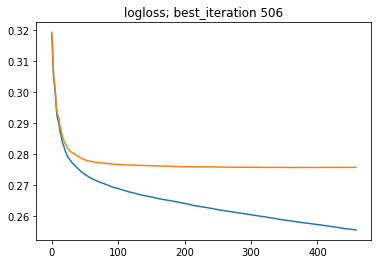

In [22]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

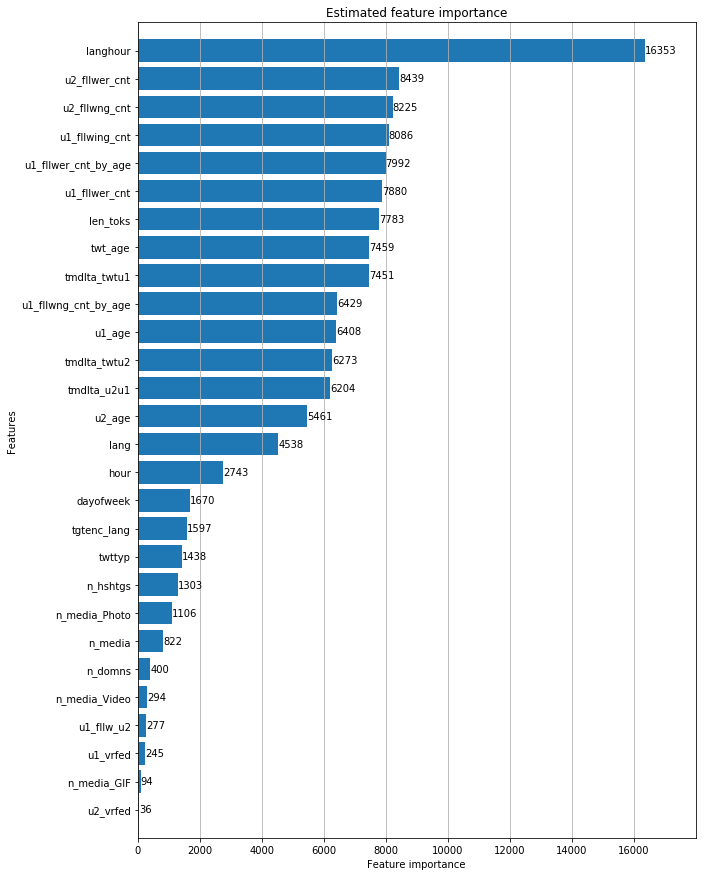

In [23]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [24]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
26,langhour,16353
5,u2_fllwer_cnt,8439
6,u2_fllwng_cnt,8225
3,u1_fllwing_cnt,8086
24,u1_fllwer_cnt_by_age,7992
2,u1_fllwer_cnt,7880
9,len_toks,7783
21,twt_age,7459
19,tmdlta_twtu1,7451
25,u1_fllwng_cnt_by_age,6429


# eval

In [25]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 12min 51s, sys: 12.6 s, total: 13min 4s
Wall time: 1min 4s


In [26]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 19 s, sys: 306 ms, total: 19.3 s
Wall time: 19.1 s


In [27]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4116
auc_vl:  0.3159
auc_val: 0.1147

rce_tr:  22.5254
rce_vl:  16.1687
rce_val: 12.7728


In [28]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.1147-12.7728


# save results

In [29]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [30]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [31]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 3.97 ms, sys: 3.53 ms, total: 7.5 ms
Wall time: 6.15 ms


In [32]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-06 19:53:54 start
2020-04-06 19:53:54 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 19:53:54 freq of tags
2020-04-06 19:53:54 done
CPU times: user 69.1 ms, sys: 68.2 ms, total: 137 ms
Wall time: 131 ms


In [33]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [34]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 0 ns, sys: 169 ms, total: 169 ms
Wall time: 29.6 ms


In [35]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)